In [1]:
%cd /content
!rm -rf /content/OptIForest
!git clone --depth 1 https://github.com/xiagll/OptIForest.git /content/OptIForest
%cd /content/OptIForest


/content
Cloning into '/content/OptIForest'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 20 (delta 0), reused 9 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (20/20), 191.65 KiB | 237.00 KiB/s, done.
/content/OptIForest


In [2]:
# Basic dependencies for baseline and OptIForest runs
!pip -q install numpy pandas scikit-learn scipy matplotlib tqdm
!pip -q install torch --index-url https://download.pytorch.org/whl/cpu

In [3]:
# Imports and environment check
import sys
import os
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, average_precision_score

print("NumPy :", np.__version__)

NumPy : 2.0.2


In [4]:
# np.mat to np.asmatrix (NumPy 2.0 compatibility)
!sed -i 's/np.mat(/np.asmatrix(/g' /content/OptIForest/detectors/opt_tree.py


In [5]:
# Original Result from Paper
!python demo.py --dataset=ad --threshold=403 --branch=0

Dataset: ad

L2OPT:
	AUC score:	 0.7739432263580505
	AUC std:	 0.006623260766517159
	PR score:	 0.43416667954357246
	PR std:	 0.04053598963069666
	Training time:	 37.17434732119242
	Testing time:	 71.43543960253398


In [6]:
# Load dataset
DATA_PATH = "/content/OptIForest/data/ad.csv"

df = pd.read_csv(DATA_PATH)

print(df.shape)

(3278, 1556)


In [7]:
# Train/test split and scaling
X_df = df.iloc[:, :-1].copy()  # All feature columns
y = df.iloc[:, -1].astype(int).to_numpy()  # Binary labels as int array

print("Class counts:", dict(zip(*np.unique(y, return_counts=True))))
print("Anomaly ratio:", float(y.mean()))

X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_df, y, test_size=0.25, random_state=42, stratify=y
)  # Stratified split to preserve class ratio

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df.values)    # Fit on train only
X_test = scaler.transform(X_test_df.values)   # Apply same scaling to test

print("Train:", X_train.shape, " Test:", X_test.shape)



Class counts: {np.int64(0): np.int64(2819), np.int64(1): np.int64(459)}
Anomaly ratio: 0.14002440512507627
Train: (2458, 1555)  Test: (820, 1555)


In [8]:
# Baseline: scikit-learn IsolationForest
iso = IsolationForest(
    n_estimators=300,
    random_state=42,
    contamination="auto",
    n_jobs=-1
)
iso.fit(X_train)

iso_scores = -iso.decision_function(X_test) # Higher = more anomalous

iso_auc = roc_auc_score(y_test, iso_scores)
iso_ap  = average_precision_score(y_test, iso_scores)
print(f"IsolationForest  AUC-ROC: {iso_auc:.4f}  |  AUC-PR: {iso_ap:.4f}")


IsolationForest  AUC-ROC: 0.6868  |  AUC-PR: 0.4508


In [9]:
import sys
sys.path.insert(0, "/content/OptIForest")
from detectors.opt_iforest import OptIForest

# OptIForest setup
THRESHOLD = 403  # LSH hash threshold used in paper/experiments
BRANCH = 0

dtc = OptIForest(lsh_family='L2OPT',
                 num_trees=100,
                 threshold=THRESHOLD,
                 branch=BRANCH,
                 granularity=1)

print("Loaded:", dtc.__class__.__name__, "| threshold =", THRESHOLD, "| branch =", BRANCH)


Loaded: OptIForest | threshold = 403 | branch = 0


In [10]:
# Train OptIForest and compute scores
dtc.fit(X_train)

if hasattr(dtc, "decision_function"):
    scores = dtc.decision_function(X_test)
    of_scores = -np.asarray(scores, dtype=float)

elif hasattr(dtc, "score_samples"):
    of_scores = -np.asarray(dtc.score_samples(X_test), dtype=float)

else:
    preds = dtc.predict(X_test)
    of_scores = (np.asarray(preds) == -1).astype(float)

of_auc = roc_auc_score(y_test, of_scores)
of_ap  = average_precision_score(y_test, of_scores)
print(f"[OptIForest] (threshold={THRESHOLD}, branch={BRANCH})  AUC-ROC: {of_auc:.4f}  |  AUC-PR: {of_ap:.4f}")


/content/OptIForest/detectors/opt_tree.py:56: RuntimeWarning: invalid value encountered in scalar divide
  children[key] = self._recursive_build(child_data, depth_limit, min(0.0, (children_count[key] -mean) /std), cur_index +1)


[OptIForest] (threshold=403, branch=0)  AUC-ROC: 0.7315  |  AUC-PR: 0.3420


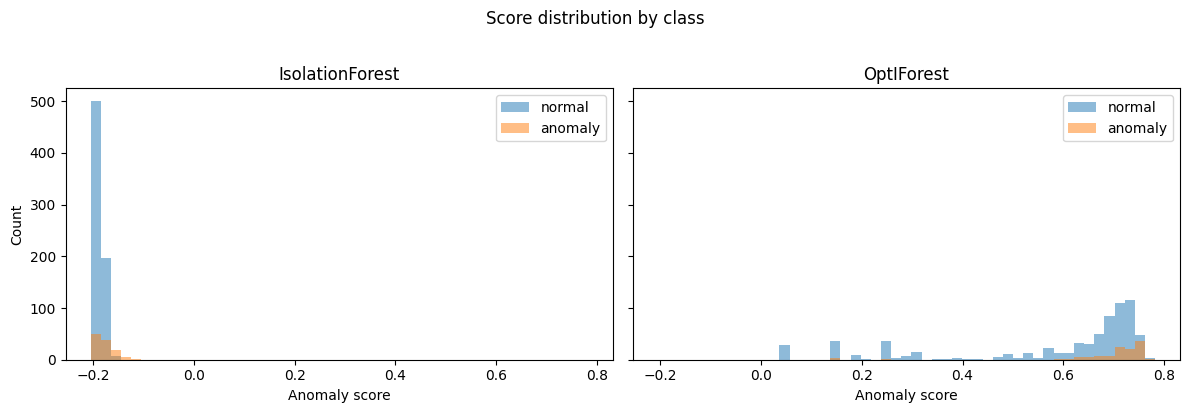

In [12]:
scores_iso = iso_scores
scores_of  = of_scores

mask_normal = (y_test == 0)
mask_anom   = (y_test == 1)

# Use the same bins across both plots for fair comparison
vmin = float(min(scores_iso.min(), scores_of.min()))
vmax = float(max(scores_iso.max(), scores_of.max()))
bins = np.linspace(vmin, vmax, 50)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Left: IsolationForest
axes[0].hist(scores_iso[mask_normal], bins=bins, alpha=0.5, label="normal")
axes[0].hist(scores_iso[mask_anom],   bins=bins, alpha=0.5, label="anomaly")
axes[0].set_title("IsolationForest")
axes[0].set_xlabel("Anomaly score")
axes[0].set_ylabel("Count")
axes[0].legend()

# Right: OptIForest
axes[1].hist(scores_of[mask_normal], bins=bins, alpha=0.5, label="normal")
axes[1].hist(scores_of[mask_anom],   bins=bins, alpha=0.5, label="anomaly")
axes[1].set_title("OptIForest")
axes[1].set_xlabel("Anomaly score")
axes[1].legend()

fig.suptitle("Score distribution by class", y=1.02)
plt.tight_layout()
plt.show()

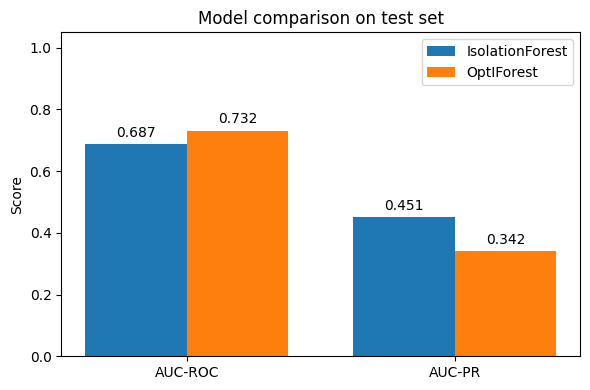

In [13]:
metrics = ["AUC-ROC", "AUC-PR"]
iso_vals = [iso_auc, iso_ap]
of_vals  = [of_auc,  of_ap]

x = np.arange(len(metrics))
width = 0.38

fig, ax = plt.subplots(figsize=(6,4))
bars1 = ax.bar(x - width/2, iso_vals, width, label="IsolationForest")
bars2 = ax.bar(x + width/2, of_vals,  width, label="OptIForest")

ax.set_ylim(0, 1.05)
ax.set_xticks(x, metrics)
ax.set_ylabel("Score")
ax.set_title("Model comparison on test set")
ax.legend()

# annotate bars with values
for bars in (bars1, bars2):
    for r in bars:
        h = r.get_height()
        ax.annotate(f"{h:.3f}", (r.get_x()+r.get_width()/2, h),
                    xytext=(0, 3), textcoords="offset points",
                    ha="center", va="bottom")

plt.tight_layout()
plt.show()
